In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import json

# Data Preprocessing

In [2]:
# We resize the input images, convert them to tensors and normalize them to [-1,1]
transform = transforms.Compose([
    transforms.Resize((128, 128)),   # Resize images to 128x128
    transforms.ToTensor(),           # Convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

# Augmented transform
augmented_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [3]:
train_dir = '/kaggle/input/inaturalist-1/inaturalist_12K/train'
test_dir = '/kaggle/input/inaturalist-1/inaturalist_12K/val'

train_dataset = ImageFolder(root=train_dir, transform=transform)
test_dataset = ImageFolder(root=test_dir, transform=transform)



In [4]:
# Load the full training dataset
full_train_dataset = ImageFolder(root=train_dir, transform=transform)

# Calculate split sizes
val_size = int(0.2 * len(full_train_dataset))
train_size = len(full_train_dataset) - val_size

# Split the dataset
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# Load the test set
test_dataset = ImageFolder(root=test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [5]:
#Make sure every class is represented equally in validation data

from collections import Counter
import matplotlib.pyplot as plt

# Get original dataset labels (from the subset indices)
val_targets = [full_train_dataset.targets[i] for i in val_dataset.indices]

# Count frequency of each class
val_class_counts = Counter(val_targets)

print(sorted(val_class_counts.items()))

[(0, 216), (1, 184), (2, 187), (3, 202), (4, 182), (5, 192), (6, 206), (7, 195), (8, 226), (9, 209)]


In [6]:
num_classes = len(full_train_dataset.classes)

class CNN(nn.Module):
    def __init__(self, num_classes, conv_filters=[96, 256, 384, 384, 256], kernel_sizes=[3, 3, 3, 3, 3], activation_fn=F.relu, fc_units=[1024],dropout=[0.0],
        use_batchnorm=False):
        super(CNN, self).__init__()
        
        
        assert len(conv_filters) == len(kernel_sizes), "conv_filters and kernel_sizes must be the same length"
        
        self.activation_fn = activation_fn
        self.use_batchnorm = use_batchnorm

        self.pool = nn.MaxPool2d(2, 2)
        
        
        self.conv_layers = nn.ModuleList()
        self.batchnorm_layers = nn.ModuleList()


        in_channels = 3  
        for out_channels, kernel_size in zip(conv_filters, kernel_sizes):
            self.conv_layers.append(nn.Conv2d(in_channels, out_channels, kernel_size, padding=kernel_size//2))
            
            if use_batchnorm:
                self.batchnorm_layers.append(nn.BatchNorm2d(out_channels))
            
            in_channels = out_channels  
        
        
        # Dynamically compute the flattened size 
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 128, 128)  
            x = dummy_input
            for idx, conv in enumerate(self.conv_layers):
                x = conv(x)
                if self.use_batchnorm:
                    x = self.batchnorm_layers[idx](x)
                x = self.activation_fn(x)
                x = self.pool(x)
            self.flattened_size = x.view(1, -1).size(1)


        # Only one dense layer
        self.fc = nn.Linear(self.flattened_size, fc_units[0])
        self.dropout = nn.Dropout(dropout)

        # Final output layer
        self.fc_out = nn.Linear(fc_units[0], num_classes)
    
    def forward(self, x):
        for idx, conv in enumerate(self.conv_layers):
            x = conv(x)
            if self.use_batchnorm:
                x = self.batchnorm_layers[idx](x)
            x = self.activation_fn(x)
            x = self.pool(x)

        x = torch.flatten(x, 1)
        
        x = self.activation_fn(self.fc(x))
        x = self.dropout(x)
        x = self.fc_out(x)
        return x

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model = CNN(num_classes, conv_filters=[64, 128, 256, 256, 128], kernel_sizes=[5, 3, 3, 3, 3], activation_fn=F.leaky_relu, fc_units=[512, 256]).to(device)

In [8]:
import wandb


In [9]:
activation_map = {
    'relu': F.relu,
    'gelu': F.gelu,
    'silu': F.silu,
    'mish': F.mish
}

In [10]:
def train(config=None):
    with wandb.init(config=config) as run:
        config = wandb.config
        
        run.name = f"filters={config.conv_filters}_act={config.activation_fn}_aug={config.use_augmentation}_bn={config.use_batchnorm}_dropout={config.dropout}"
        run.save()

        # Choose transform for training
        if config.use_augmentation:
            train_transform = augmented_transform
        else:
            train_transform = transform

        # Load full dataset with chosen transform
        full_train_dataset = ImageFolder(train_dir, transform=train_transform)

        # Split into train and val
        val_size = int(0.2 * len(full_train_dataset))
        train_size = len(full_train_dataset) - val_size
        train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

        # Set val transform to basic (no augmentation)
        val_dataset.dataset.transform = transform

        # Data loaders
        train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=2)
        val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False, num_workers=2)


        # Model instantiation 
        model = CNN(
                  num_classes=num_classes,
                  conv_filters=config.conv_filters,
                  kernel_sizes=[3] * len(config.conv_filters), #why 3?
                  activation_fn=activation_map[config.activation_fn],
                  fc_units=config.fc_units,
                  dropout=config.dropout,
                  use_batchnorm=config.use_batchnorm
              ).to(device)

        # Loss and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)

        
        best_val_acc = 0.0

        for epoch in range(config.epochs):
            model.train()
            running_loss = 0.0
            correct_train = 0
            total_train = 0

            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

            train_loss = running_loss / len(train_loader)
            train_acc = 100 * correct_train / total_train

            # Validation phase
            model.eval()
            correct_val = 0
            total_val = 0
            with torch.no_grad():
                for val_inputs, val_labels in val_loader:
                    val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                    val_outputs = model(val_inputs)
                    _, val_predicted = torch.max(val_outputs.data, 1)
                    total_val += val_labels.size(0)
                    correct_val += (val_predicted == val_labels).sum().item()

            val_acc = 100 * correct_val / total_val
            model.train()

            print(f"Epoch {epoch+1}/{config.epochs}")
            print(f"  Training Loss: {train_loss:.4f} | Training Accuracy: {train_acc:.2f}%")
            print(f"  Validation Accuracy: {val_acc:.2f}%\n")

            # Save best model and config
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(model.state_dict(), "best_model.pth")
                with open("best_config.json", "w") as f:
                    json.dump(dict(config), f)

            # Log metrics to W&B
            wandb.log({
                "train_loss": train_loss,
                "train_acc": train_acc,
                "val_acc": val_acc
            })

        # Test accuracy (do not log to W&B)
        model.eval()
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for test_inputs, test_labels in test_loader:
                test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
                test_outputs = model(test_inputs)
                _, test_preds = torch.max(test_outputs.data, 1)
                total_test += test_labels.size(0)
                correct_test += (test_preds == test_labels).sum().item()

        test_acc = 100 * correct_test / total_test
        print(f"Final Test Accuracy: {test_acc:.2f}%")


In [11]:
sweep_config = {
    'method': 'bayes',  
    'metric': {
        'name': 'val_acc',
        'goal': 'maximize'
    },
    'parameters': {
        'lr': {
            'values': [0.001, 0.0005, 0.0001]
        },
        'epochs': {
            'values': [5,10]
        },
        'conv_filters': {
            'values': [
                [32, 64, 128, 256, 512],
                [64, 128, 256, 512, 1024],
                [32, 64, 64, 128, 128],
                [128, 128, 128, 128, 128],
                [1024,512,256,128,64]
            ]
        },
        'activation_fn': {
            'values': ['relu', 'gelu', 'silu', 'mish']
        },
        'fc_units': {
            'values': [[256],[512],[1024],]
        },
        'batch_size': {'values': [32, 64]},
        'use_batchnorm': {'values': [True, False]},
        'use_augmentation': {'values': [True, False]},
        'dropout': {'values': [0,0.1,0.2,0.3,0.5]}

    }
}


In [12]:
wandb.login(key='af7d7cf29d8954a13afb06c7a0d0c196c36ac51b')

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ma24m003 (ma24m003-iit-madras). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [13]:
# Create sweep
sweep_id = wandb.sweep(sweep_config, project="inaturalist-hyperparam-tuning")

# Launch sweep agents
wandb.agent(sweep_id, function=train, count=5)  # runs 10 experiments

wandb.finish()


Create sweep with ID: afq4xp7u
Sweep URL: https://wandb.ai/ma24m003-iit-madras/inaturalist-hyperparam-tuning/sweeps/afq4xp7u


wandb: Agent Starting Run: 29o1h75z with config:
wandb: 	activation_fn: silu
wandb: 	batch_size: 64
wandb: 	conv_filters: [128, 128, 128, 128, 128]
wandb: 	dropout: 0.3
wandb: 	epochs: 5
wandb: 	fc_units: [512]
wandb: 	lr: 0.0005
wandb: 	use_augmentation: True
wandb: 	use_batchnorm: True


wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


Epoch 1/5
  Training Loss: 2.0722 | Training Accuracy: 25.74%
  Validation Accuracy: 28.71%

Epoch 2/5
  Training Loss: 1.9177 | Training Accuracy: 32.27%
  Validation Accuracy: 32.92%

Epoch 3/5
  Training Loss: 1.8067 | Training Accuracy: 35.94%
  Validation Accuracy: 34.47%

Epoch 4/5
  Training Loss: 1.7152 | Training Accuracy: 39.84%
  Validation Accuracy: 33.82%

Epoch 5/5
  Training Loss: 1.6266 | Training Accuracy: 42.61%
  Validation Accuracy: 33.47%

Final Test Accuracy: 34.15%


train_acc,▁▄▅▇█
train_loss,█▆▄▂▁
val_acc,▁▆█▇▇
train_acc,42.6125
train_loss,1.62661
val_acc,33.46673


wandb: Agent Starting Run: c87cdkjp with config:
wandb: 	activation_fn: gelu
wandb: 	batch_size: 32
wandb: 	conv_filters: [32, 64, 64, 128, 128]
wandb: 	dropout: 0
wandb: 	epochs: 10
wandb: 	fc_units: [512]
wandb: 	lr: 0.001
wandb: 	use_augmentation: False
wandb: 	use_batchnorm: True


Epoch 1/10
  Training Loss: 2.1253 | Training Accuracy: 22.96%
  Validation Accuracy: 25.41%

Epoch 2/10
  Training Loss: 1.9887 | Training Accuracy: 28.62%
  Validation Accuracy: 28.16%

Epoch 3/10
  Training Loss: 1.8870 | Training Accuracy: 33.24%
  Validation Accuracy: 31.02%

Epoch 4/10
  Training Loss: 1.7972 | Training Accuracy: 36.52%
  Validation Accuracy: 32.42%

Epoch 5/10
  Training Loss: 1.7220 | Training Accuracy: 39.23%
  Validation Accuracy: 32.62%

Epoch 6/10
  Training Loss: 1.6462 | Training Accuracy: 41.61%
  Validation Accuracy: 35.07%

Epoch 7/10
  Training Loss: 1.5580 | Training Accuracy: 44.79%
  Validation Accuracy: 36.27%

Epoch 8/10
  Training Loss: 1.4581 | Training Accuracy: 48.86%
  Validation Accuracy: 38.37%

Epoch 9/10
  Training Loss: 1.3416 | Training Accuracy: 52.77%
  Validation Accuracy: 36.82%

Epoch 10/10
  Training Loss: 1.2350 | Training Accuracy: 56.65%
  Validation Accuracy: 35.77%

Final Test Accuracy: 37.85%


train_acc,▁▂▃▄▄▅▆▆▇█
train_loss,█▇▆▅▅▄▄▃▂▁
val_acc,▁▂▄▅▅▆▇█▇▇
train_acc,56.65
train_loss,1.23501
val_acc,35.76788


wandb: Agent Starting Run: ogwf0jtm with config:
wandb: 	activation_fn: silu
wandb: 	batch_size: 64
wandb: 	conv_filters: [32, 64, 64, 128, 128]
wandb: 	dropout: 0
wandb: 	epochs: 5
wandb: 	fc_units: [1024]
wandb: 	lr: 0.0001
wandb: 	use_augmentation: False
wandb: 	use_batchnorm: False


Epoch 1/5
  Training Loss: 2.2684 | Training Accuracy: 14.03%
  Validation Accuracy: 18.41%

Epoch 2/5
  Training Loss: 2.1982 | Training Accuracy: 18.45%
  Validation Accuracy: 20.96%

Epoch 3/5
  Training Loss: 2.1502 | Training Accuracy: 21.40%
  Validation Accuracy: 24.61%

Epoch 4/5
  Training Loss: 2.1008 | Training Accuracy: 23.93%
  Validation Accuracy: 24.11%

Epoch 5/5
  Training Loss: 2.0287 | Training Accuracy: 27.71%
  Validation Accuracy: 28.26%

Final Test Accuracy: 27.90%


train_acc,▁▃▅▆█
train_loss,█▆▅▃▁
val_acc,▁▃▅▅█
train_acc,27.7125
train_loss,2.02867
val_acc,28.26413


wandb: Agent Starting Run: qhiiojrd with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	conv_filters: [1024, 512, 256, 128, 64]
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	fc_units: [256]
wandb: 	lr: 0.0001
wandb: 	use_augmentation: False
wandb: 	use_batchnorm: True


Traceback (most recent call last):
  File "<ipython-input-10-f24c5ef9b2b2>", line 60, in train
    loss.backward()
  File "/usr/local/lib/python3.10/dist-packages/torch/_tensor.py", line 581, in backward
    torch.autograd.backward(
  File "/usr/local/lib/python3.10/dist-packages/torch/autograd/__init__.py", line 347, in backward
    _engine_run_backward(
  File "/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py", line 825, in _engine_run_backward
    return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
torch.OutOfMemoryError: CUDA out of memory. Tried to allocate 4.00 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.01 GiB is free. Process 2475 has 12.73 GiB memory in use. Of the allocated memory 11.08 GiB is allocated by PyTorch, and 1.51 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See d

Run qhiiojrd errored:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "<ipython-input-10-f24c5ef9b2b2>", line 60, in train
    loss.backward()
  File "/usr/local/lib/python3.10/dist-packages/torch/_tensor.py", line 581, in backward
    torch.autograd.backward(
  File "/usr/local/lib/python3.10/dist-packages/torch/autograd/__init__.py", line 347, in backward
    _engine_run_backward(
  File "/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py", line 825, in _engine_run_backward
    return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
torch.OutOfMemoryError: CUDA out of memory. Tried to allocate 4.00 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.01 GiB is free. Process 2475 has 12.73 GiB memory in use. Of the allocated memory 11.08 GiB is allocated by PyTorch, and 1.51 GiB is reserved by PyTorch but unallocat

Epoch 1/5
  Training Loss: 2.2109 | Training Accuracy: 18.64%
  Validation Accuracy: 25.81%

Epoch 2/5
  Training Loss: 2.0694 | Training Accuracy: 25.07%
  Validation Accuracy: 27.86%

Epoch 3/5
  Training Loss: 1.9806 | Training Accuracy: 29.52%
  Validation Accuracy: 30.87%

Epoch 4/5
  Training Loss: 1.9072 | Training Accuracy: 31.82%
  Validation Accuracy: 28.86%

Epoch 5/5
  Training Loss: 1.8123 | Training Accuracy: 35.41%
  Validation Accuracy: 36.57%

Final Test Accuracy: 35.15%


train_acc,▁▄▆▇█
train_loss,█▆▄▃▁
val_acc,▁▂▄▃█
train_acc,35.4125
train_loss,1.8123
val_acc,36.56828


> Best model evaluation on test dataset

In [14]:
# Load config and model
with open("best_config.json", "r") as f:
    best_config = json.load(f)

model = CNN(
    num_classes=num_classes,
    conv_filters=best_config["conv_filters"],
    kernel_sizes=[3] * len(best_config["conv_filters"]),
    activation_fn=activation_map[best_config["activation_fn"]],
    fc_units=best_config["fc_units"],
    dropout=best_config["dropout"],
    use_batchnorm=best_config["use_batchnorm"]
).to(device)

model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# Evaluate on test set
correct_test = 0
total_test = 0
with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
        outputs = model(test_inputs)
        _, preds = torch.max(outputs, 1)
        correct_test += (preds == test_labels).sum().item()
        total_test += test_labels.size(0)

test_acc = 100 * correct_test / total_test
print(f"Loaded Best Model Test Accuracy: {test_acc:.2f}%")


<ipython-input-14-41d3528c7079>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


Loaded Best Model Test Accuracy: 35.15%


In [15]:
best_config

{'activation_fn': 'silu',
 'batch_size': 32,
 'conv_filters': [128, 128, 128, 128, 128],
 'dropout': 0.3,
 'epochs': 5,
 'fc_units': [512],
 'lr': 0.001,
 'use_augmentation': True,
 'use_batchnorm': False}

In [16]:
inputs, labels = next(iter(test_loader))
inputs, labels = inputs.to(device), labels.to(device)
outputs = model(inputs)
preds = outputs.argmax(dim=1)
print("Predicted:", preds[:20].cpu().numpy())
print("Actual   :", labels[:20].cpu().numpy())


Predicted: [9 6 7 0 8 7 5 5 7 1 9 4 9 4 0 7 7 2 5 6]
Actual   : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [17]:
torch.save(model.state_dict(), "best_model.pth")


<ipython-input-18-05bf96a7c4a2>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


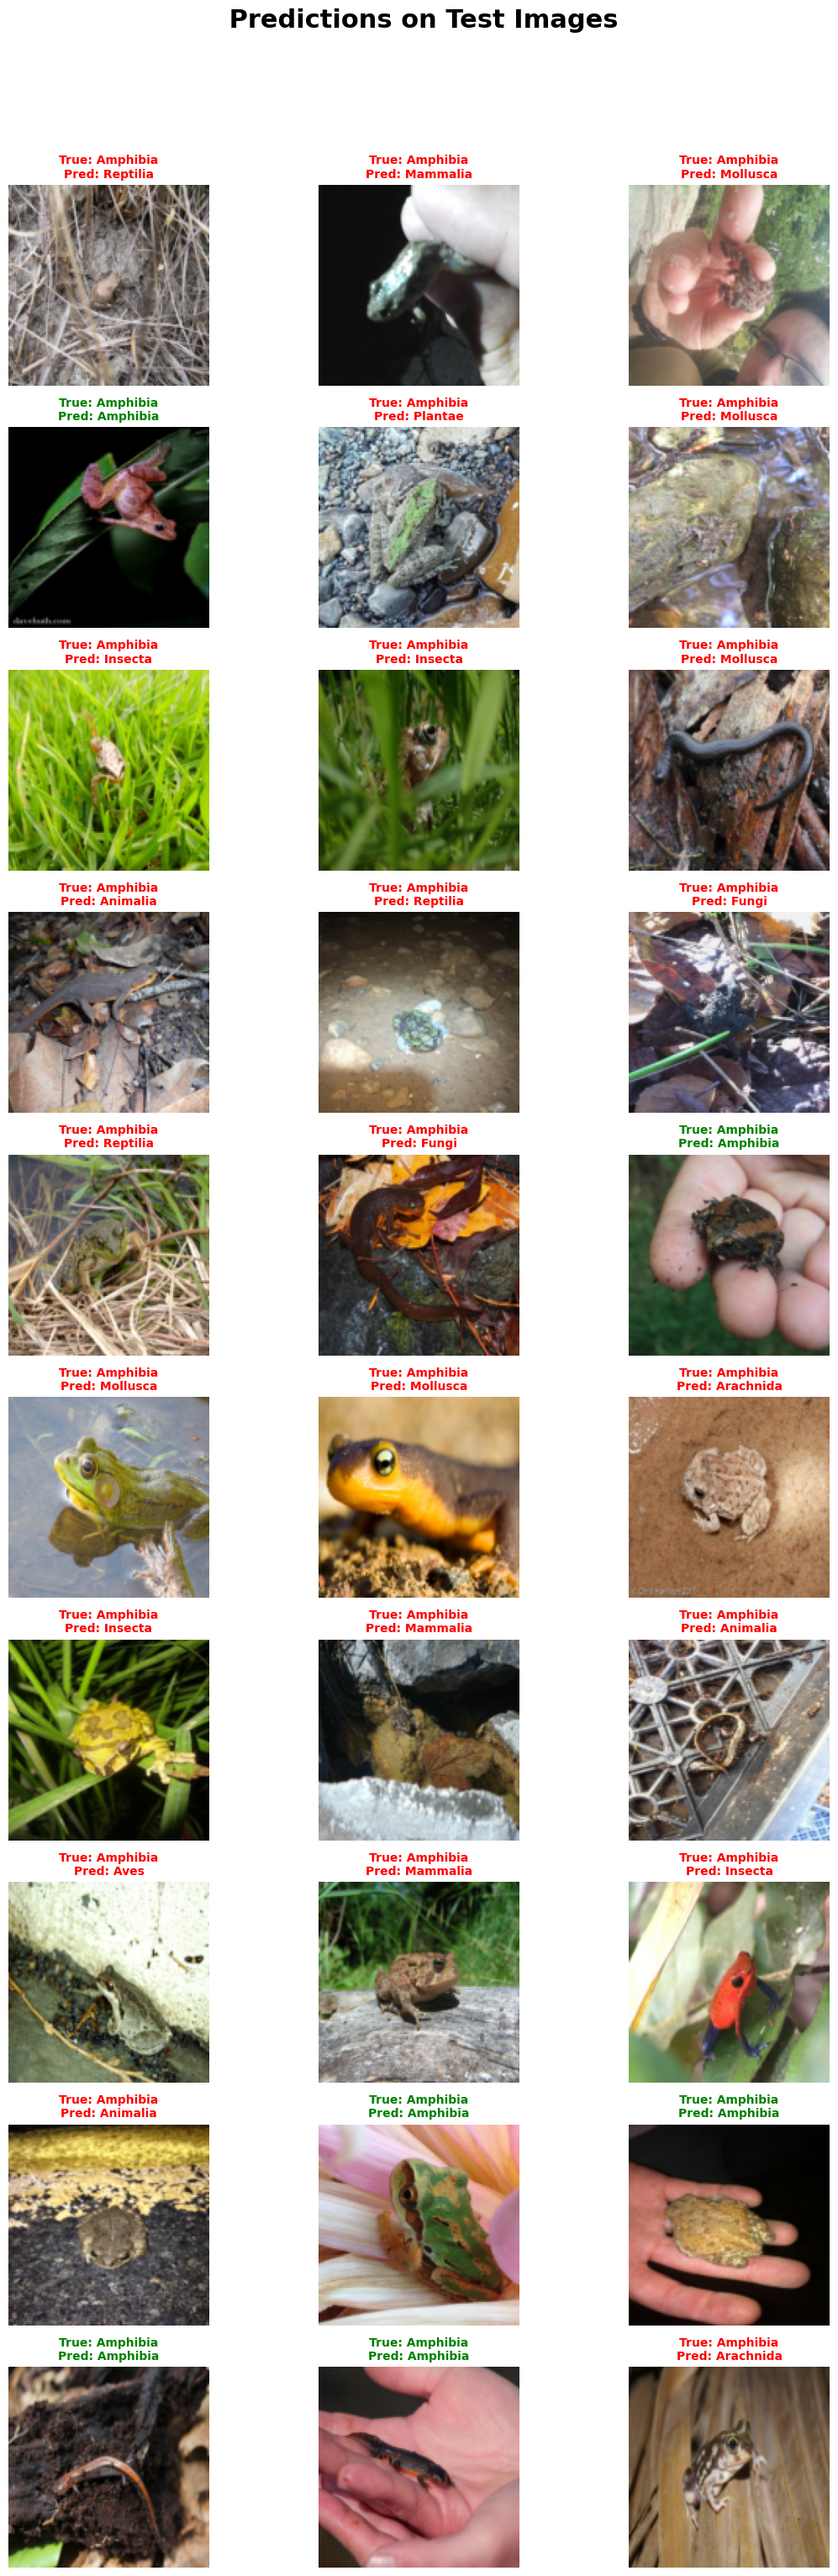

In [18]:
import matplotlib.pyplot as plt

# Load the model
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# Get a batch of test images
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

# Get model predictions
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

# Move tensors to CPU for visualization
images = images.cpu()
labels = labels.cpu()
predicted = predicted.cpu()

# Class names
class_names = test_dataset.classes

# Function to unnormalize images
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))

# Plot the 10x3 grid
fig, axes = plt.subplots(10, 3, figsize=(12, 30))
fig.suptitle(' Predictions on Test Images', fontsize=22, fontweight='bold', y=1.02)

for i in range(30):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    img = imshow(images[i])
    ax.imshow(img)
    true_label = class_names[labels[i]]
    pred_label = class_names[predicted[i]]
    
    if true_label == pred_label:
        title_color = 'green'
    else:
        title_color = 'red'
    
    ax.set_title(f"True: {true_label}\nPred: {pred_label}", color=title_color, fontsize=10, fontweight='bold')
    ax.axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()